In [1]:
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import gmres, LinearOperator
import matplotlib.pyplot as plt

from ilup import ilu_p, compute_levels

## 1. 2D-Possion 2D Test with GMERES

In [2]:
def poisson_2d(n):
    e = np.ones(n)
    T = sp.diags([e, -4 * e, e], [-1, 0, 1], shape=(n, n))
    I = sp.identity(n)
    A = sp.kron(I, T) + sp.kron(sp.diags([e, e], [-1, 1], shape=(n, n)), I)

    A = A.tocsr()
    x = np.linspace(0, 1, n+2)[1:-1]
    X, Y = np.meshgrid(x, x, indexing='ij')
    u_exact = np.sin(np.pi * X) * np.sin(np.pi * Y)
    b = (2*np.pi**2) * u_exact.reshape(-1)
    return A, b


def test_gmres(N, p=0):
    A, b = poisson_2d(N)
    L, U = ilu_p(A, p)
    n = A.shape[0]

    # M(x) = U^-1 L^-1 x
    def Mx(x):
        # solve L y = x
        y = np.zeros_like(x)
        for i in range(n):
            tmp = x[i]
            for j in range(i):
                tmp -= L[i, j] * y[j]
            y[i] = tmp / L[i, i]

        # solve U z = y
        z = np.zeros_like(x)
        for i in reversed(range(n)):
            tmp = y[i]
            for j in range(i+1, n):
                tmp -= U[i, j] * z[j]
            z[i] = tmp / U[i, i]

        return z

    M = LinearOperator((n, n), matvec=Mx)

    def gmres_callback(resid):
        global iteration, res
        iteration += 1
        res[iteration] = resid

    x0 = np.zeros(n, dtype=np.float64)
    global iteration, res
    iteration  = 0
    res = {}
    x, _ = gmres(A, b, x0=x0, M=M, callback=gmres_callback, callback_type='legacy')
    # err = np.linalg.norm(x - np.linalg.inv(A.toarray()).dot(b))
    return x, res

## 2. Test for p

In [ ]:
result = {}
n_list = [3, 5, 10, 20]
p_list = [0, 1, 2, 3, 4]

for n in n_list:
    result[n] = {}
    for p in p_list:
        x, res = test_gmres(n, p)
        result[n][p] = res.copy()

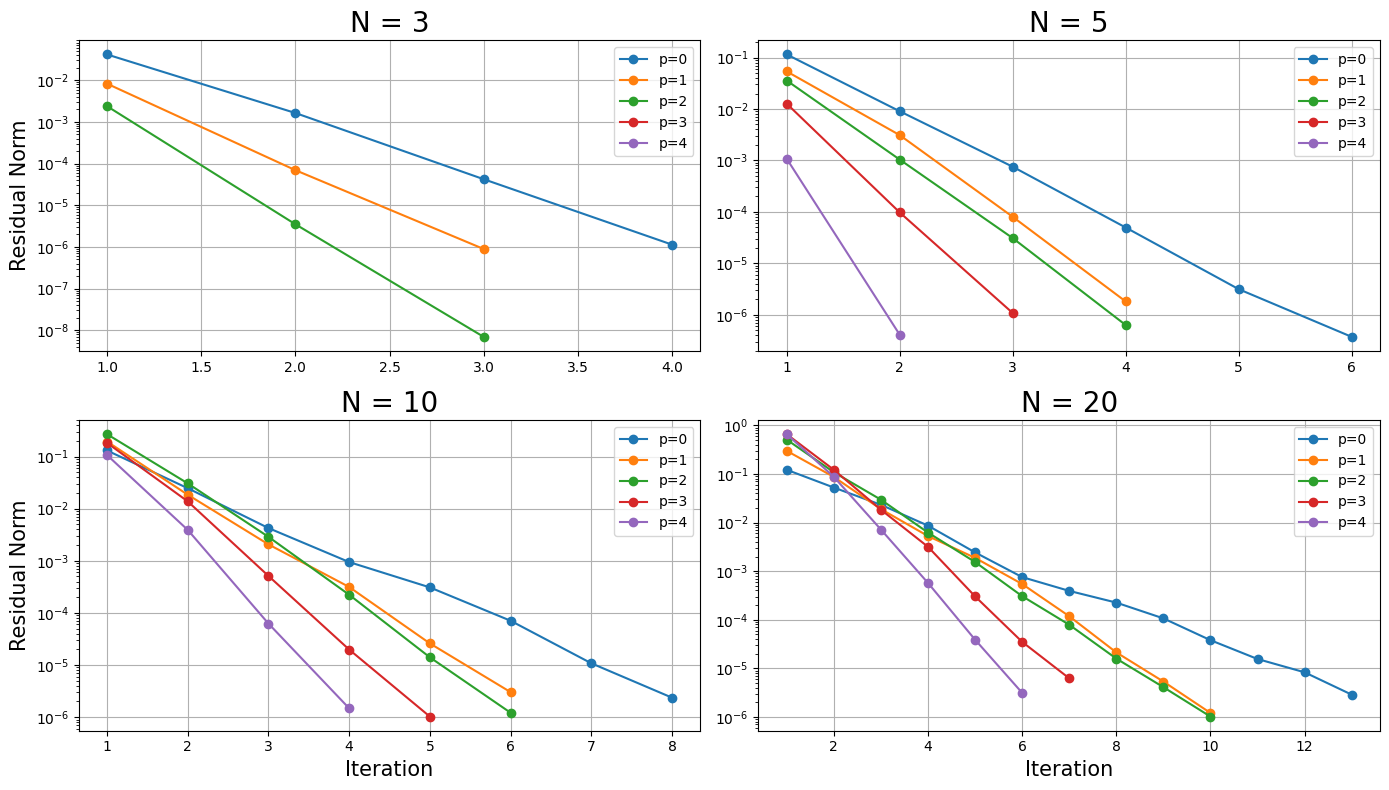

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.ravel()

for i, n in enumerate(n_list):
    ax = axes[i]
    for p in p_list:
        ax.plot(result[n][p].keys(), result[n][p].values(), marker='o', label=f"p={p}")
    ax.set_yscale('log')
    if i > 1:
        ax.set_xlabel("Iteration", fontsize=15)
    if i % 2 == 0:
        ax.set_ylabel("Residual Norm", fontsize=15)
    ax.set_title(f"N = {n_list[i]}", fontsize=20)
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.savefig('./experiments.png', dpi=300)
plt.show()

## 3. Plot the level-of-fill

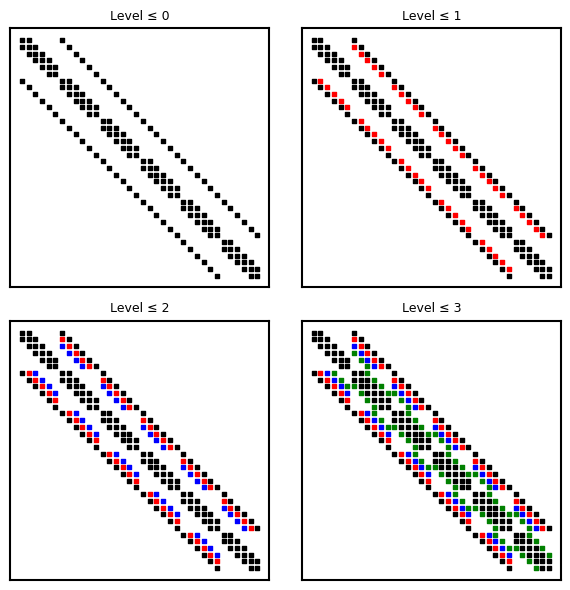

In [5]:
n = 6
pmax = 3
A, b = poisson_2d(n)
lev = compute_levels(A.todense(), pmax)

colors = {0: 'black', 1: 'red', 2: 'blue', 3: 'green'}
titles = ['Level ≤ 0', 'Level ≤ 1', 'Level ≤ 2', 'Level ≤ 3']

fig, axes = plt.subplots(2, 2, figsize=(6, 6))
axes = axes.flatten()

for idx, p in enumerate(range(0, 4)):
    ax = axes[idx]
    for i in range(lev.shape[0]):
        for j in range(lev.shape[1]):
            l = lev[i, j]
            if l == np.inf or l > p:
                continue
            ax.scatter(j, lev.shape[0] - 1 - i, marker='s', s=8, color=colors[int(l)])
    ax.set_title(titles[idx], fontsize=9)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')

    ax.spines['left'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['top'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)
        spine.set_color('black')

plt.tight_layout()
plt.savefig('./level.png', dpi=300)
plt.show()
